<h1 style="text-align: center;">Volatility for daily time series</h1>

## 1. Exploratory data analysis

In [3]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [4]:
# Download data for TSLA
start_date = '2015-01-01'
end_date = '2024-12-31'

df = yf.download('TSLA', start=start_date, end=end_date)
df = df[['Close']].rename(columns={'Close': 'Price'})
df['LogReturn'] = np.log(df['Price'] / df['Price'].shift(1))
df.dropna(inplace=True)

C:\Users\Manuel\AppData\Local\Temp\ipykernel_9532\1987597260.py:5: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download('TSLA', start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed



===== Tesla Descriptive Statistics (2015-2024) =====
count    2514.000000
mean        0.001333
std         0.035911
min        -0.236518
25%        -0.016292
50%         0.001264
75%         0.019073
max         0.198187
Name: LogReturn, dtype: float64


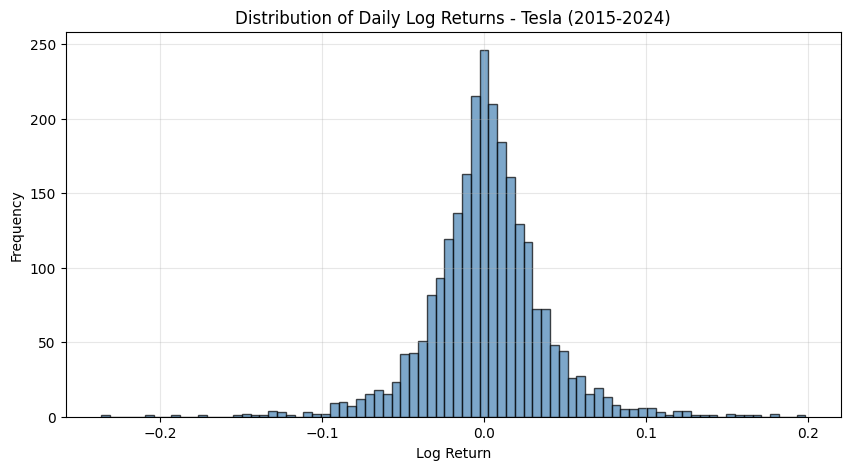

In [5]:
# Descriptive statistics and first visual check
print(f"\n===== Tesla Descriptive Statistics (2015-2024) =====")
print(df['LogReturn'].describe())

plt.figure(figsize=(10,5))
plt.hist(df['LogReturn'], bins=80, alpha=0.7, color='steelblue', edgecolor='k')
plt.title(f"Distribution of Daily Log Returns - Tesla (2015-2024)")
plt.xlabel("Log Return")
plt.ylabel("Frequency")
plt.grid(alpha=0.3)
plt.show()

In [6]:
# Asymmetry analysis
df['PrevReturn'] = df['LogReturn'].shift(1)
df['SquaredReturn'] = df['LogReturn']**2
df.dropna(inplace=True)
cond_means = df.groupby(df['PrevReturn'] < 0)['SquaredReturn'].mean()

print("\n=== Descriptive Asymmetry Analysis: Tesla (2015–2024) ===")
print(f"- The average squared log-return after a GAIN is {cond_means[False]:.6f}.")
print(f"- The average squared log-return after a LOSS is {cond_means[True]:.6f}.")


=== Descriptive Asymmetry Analysis: Tesla (2015–2024) ===
- The average squared log-return after a GAIN is 0.001259.
- The average squared log-return after a LOSS is 0.001325.


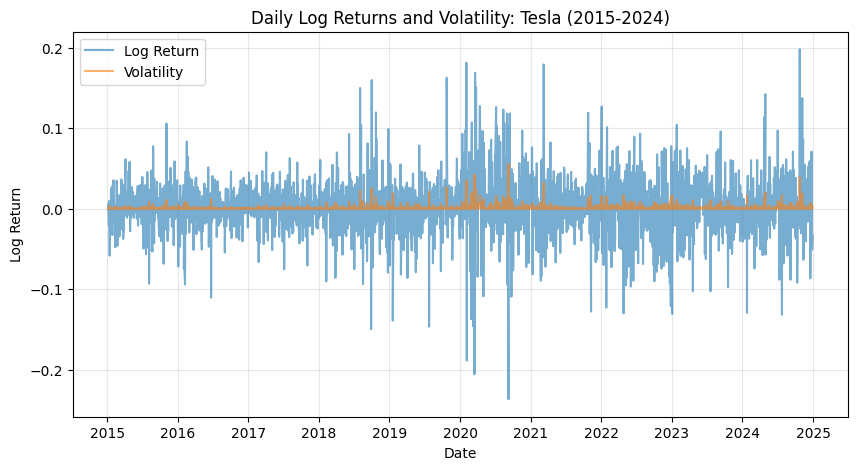

In [7]:
# Visual time series
plt.figure(figsize=(10,5))
plt.plot(df.index, df['LogReturn'], label='Log Return', alpha=0.6)
plt.plot(df.index, df['SquaredReturn'], label='Volatility', alpha=0.6)
plt.title('Daily Log Returns and Volatility: Tesla (2015-2024)')
plt.xlabel('Date')
plt.ylabel('Log Return')
plt.legend()
plt.grid(alpha=0.3)
# plt.savefig("plot_tesla.png", dpi=300, bbox_inches='tight')
plt.show()

## 2. Variation of GARCH models and the leverage effect

In [9]:
from scipy import stats
from dataclasses import dataclass
from typing import Tuple, Callable, Dict   # Callable: function type
from scipy.optimize import minimize

In [11]:
"""
T-GARCH vs GARCH likelihood-ratio test on TSLA log-returns

Given: a DataFrame `df` with a 'LogReturn' column already computed.
Goal: test H0: alpha_- = alpha_+ using a likelihood ratio test.

Model (with two alpha parameters):
  h_t = ω + α_+ ε_{t-1}^2 I(ε_{t-1} ≥ 0) + α_- ε_{t-1}^2 I(ε_{t-1} < 0) + β h_{t-1}
Compared with the classical GARCH(1,1) (constraint):
  h_t = ω + α ε_{t-1}^2 + β h_{t-1}

Practical notes:
- Gaussian innovations N(0,1). Mean of returns = 0.
- Multiple starting points are used for optimization.
- Constraints: positivity of parameters; approximate stationarity condition (ᾱ + β < 1 for TGARCH, with ᾱ = (α_+ + α_-)/2; α + β < 1 for GARCH).
- Initial variance is set to σ̂² or to the unconditional variance if valid.
- LR = 2 (ℓ_unrestricted − ℓ_restricted), p-value = 1 − F_{χ¹²}(LR).
"""

# -------------------------------
# Utility functions
# -------------------------------

def ensure_1d(a: np.ndarray) -> np.ndarray:
    a = np.asarray(a)
    return a.reshape(-1)

@dataclass
class FitResult:
    params: Dict[str, float]
    loglik: float
    success: bool
    message: str
    nit: int

# -------------------------------
# Likelihood functions
# -------------------------------

def _init_variance_GARCH(e2: np.ndarray, omega: float, alpha: float, beta: float) -> float:
    denom = 1.0 - alpha - beta
    if denom > 1e-6 and omega > 0:
        return float(max(1e-12, omega / denom))
    return float(np.maximum(1e-12, np.var(e2)))   # Initial variance should not be too small

def _init_variance_TGARCH(e2: np.ndarray, omega: float, alpha_p: float, alpha_m: float, beta: float) -> float:
    alpha_bar = 0.5 * (alpha_p + alpha_m)
    denom = 1.0 - alpha_bar - beta
    if denom > 1e-6 and omega > 0:
        return float(max(1e-12, omega / denom))
    return float(np.maximum(1e-12, np.var(e2)))

def garch11_negloglik(theta: np.ndarray, r: np.ndarray) -> float:
    omega, alpha, beta = np.clip(theta, 1e-12, None)   # Parameters > 1e-12
    penalty = 0.0
    if alpha + beta >= 0.999:
        penalty += 1e6 * (alpha + beta - 0.999 + 1e-9)**2   # Otherwise ll is difficult to optimize if there isn't stationarity
    T = r.shape[0]   # Length of r
    e = r
    e2 = e * e
    h = np.empty(T, dtype=float)
    h0 = _init_variance_GARCH(e2, omega, alpha, beta)
    h[0] = h0
    for t in range(1, T):
        h[t] = omega + alpha * e2[t-1] + beta * h[t-1]
        if not np.isfinite(h[t]) or h[t] <= 0:
            return 1e12
    ll = -0.5 * (np.log(2.0 * np.pi) + np.log(h) + e2 / h).sum()   # Real ll
    return float(-(ll) + penalty)   # Negative ll (in order to minimize)

def tgarch11_asym_negloglik(theta: np.ndarray, r: np.ndarray) -> float:
    omega, a_p, a_m, beta = np.clip(theta, 1e-12, None)
    penalty = 0.0
    if (0.5 * (a_p + a_m) + beta) >= 0.999:
        penalty += 1e6 * ((0.5 * (a_p + a_m) + beta) - 0.999 + 1e-9)**2
    T = r.shape[0]
    e = r
    e2 = e * e
    Ipos = (e >= 0.0).astype(float)
    Ineg = 1.0 - Ipos
    h = np.empty(T, dtype=float)
    h0 = _init_variance_TGARCH(e2, omega, a_p, a_m, beta)
    h[0] = h0
    for t in range(1, T):
        h[t] = omega + (a_p * Ipos[t-1] + a_m * Ineg[t-1]) * e2[t-1] + beta * h[t-1]
        if not np.isfinite(h[t]) or h[t] <= 0:
            return 1e12
    ll = -0.5 * (np.log(2.0 * np.pi) + np.log(h) + e2 / h).sum()
    return float(-(ll) + penalty)

# -------------------------------
# MLE estimation with multi-start
# -------------------------------

def _multistart_minimize(fun: Callable[[np.ndarray, np.ndarray], float],
                         r: np.ndarray,
                         theta0_list: Tuple[np.ndarray, ...],
                         bounds: Tuple[Tuple[float, float], ...],
                         maxiter: int = 50_000) -> Tuple[np.ndarray, float, bool, str, int]:
    best_val = np.inf
    best_x = None
    best_res = None
    for theta0 in theta0_list:
        res = minimize(fun, x0=np.array(theta0, dtype=float), args=(r,),   # args: additional arguments to fun
                       method='L-BFGS-B', bounds=bounds,   # L-BFGS-B: Limited-memory Broyden–Fletcher–Goldfarb–Shanno with Bounds; quasi-Newton
                       options={'maxiter': maxiter, 'ftol': 1e-12})
        val = res.fun
        if val < best_val:
            best_val = val
            best_x = res.x
            best_res = res
    return best_x, best_val, bool(best_res.success), best_res.message, best_res.nit   # nit: number of iterations

def fit_garch11(r: np.ndarray) -> FitResult:
    r = ensure_1d(r)
    s2 = float(np.var(r))
    inits = (
        np.array([0.1 * s2, 0.05, 0.90]),
        np.array([0.05 * s2, 0.10, 0.85]),
        np.array([0.01 * s2, 0.07, 0.90]),
    )
    bounds = ((1e-12, None), (1e-12, 0.999), (1e-12, 0.999))
    x, fval, ok, msg, nit = _multistart_minimize(garch11_negloglik, r, inits, bounds)
    ll = -fval
    pars = {'omega': float(x[0]), 'alpha': float(x[1]), 'beta': float(x[2])}
    return FitResult(pars, ll, ok, msg, nit)

def fit_tgarch11_asym(r: np.ndarray) -> FitResult:
    r = ensure_1d(r)
    s2 = float(np.var(r))
    inits = (
        np.array([0.1 * s2, 0.05, 0.05, 0.90]),
        np.array([0.05 * s2, 0.10, 0.02, 0.85]),
        np.array([0.01 * s2, 0.07, 0.07, 0.90]),
    )
    bounds = ((1e-12, None), (1e-12, 0.999), (1e-12, 0.999), (1e-12, 0.999))
    x, fval, ok, msg, nit = _multistart_minimize(tgarch11_asym_negloglik, r, inits, bounds)
    ll = -fval
    pars = {'omega': float(x[0]), 'alpha_plus': float(x[1]), 'alpha_minus': float(x[2]), 'beta': float(x[3])}
    return FitResult(pars, ll, ok, msg, nit)

# -------------------------------
# LR test H0: alpha_- = alpha_+
# -------------------------------

def lr_test_alpha_symmetry(r: np.ndarray) -> Dict[str, float]:
    res_restr = fit_garch11(r)
    res_unres = fit_tgarch11_asym(r)
    LR = 2.0 * (res_unres.loglik - res_restr.loglik)
    pval = stats.chi2.sf(LR, df=1)
    out = {
        'LR': float(LR),
        'p_value': float(pval),
        'df': 1.0
    }
    return out

# -------------------------------
# Usage 
# -------------------------------

if __name__ == '__main__':
    r = df['LogReturn'].values.astype(float)
    res_g = fit_garch11(r)
    res_t = fit_tgarch11_asym(r)
    lr = lr_test_alpha_symmetry(r)

    print('\n=== GARCH(1,1) (constraint α_- = α_+) ===')
    print({k: round(v, 6) for k, v in res_g.params.items()})
    print(f'logLik: {res_g.loglik:.3f}, success={res_g.success}, nit={res_g.nit}')

    print('\n=== T-GARCH(1,1) (two alphas) ===')
    print({k: round(v, 6) for k, v in res_t.params.items()})
    print(f'logLik: {res_t.loglik:.3f}, success={res_t.success}, nit={res_t.nit}')

    print('\n=== LR test H0: alpha_- = alpha_+ ===')
    print(f"LR statistic: {lr['LR']:.3f}, df=1, p-value: {lr['p_value']:.6f}")


=== GARCH(1,1) (constraint α_- = α_+) ===
{'omega': 2e-05, 'alpha': 0.051831, 'beta': 0.932962}
logLik: 4961.817, success=True, nit=14

=== T-GARCH(1,1) (two alphas) ===
{'omega': 1.1e-05, 'alpha_plus': 0.034162, 'alpha_minus': 0.033351, 'beta': 0.957136}
logLik: 4964.611, success=True, nit=71

=== LR test H0: alpha_- = alpha_+ ===
LR statistic: 5.586, df=1, p-value: 0.018103


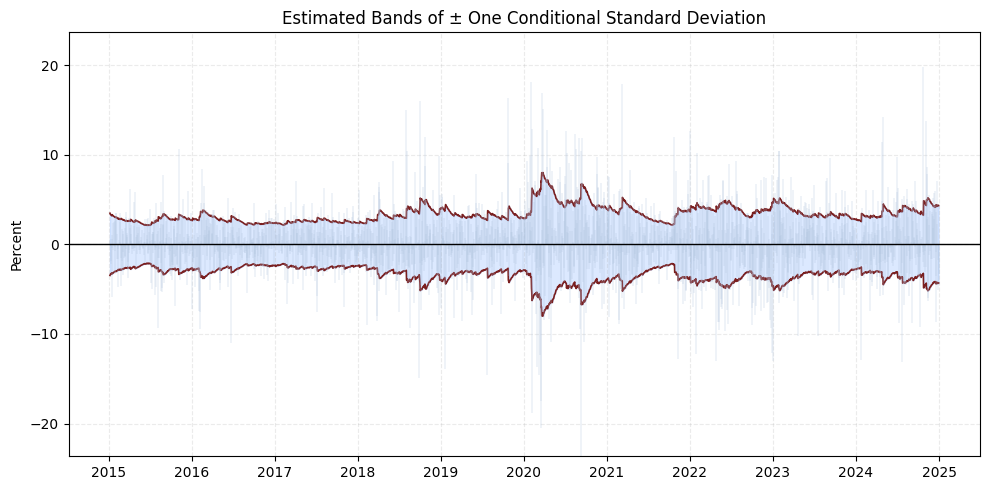

In [20]:
# Compute conditional variance sequence h_t for TGARCH(1,1)
def compute_ht_tgarch(r: np.ndarray, omega: float, alpha_plus: float, alpha_minus: float, beta: float) -> np.ndarray:
    """
    Reconstruct the conditional variance sequence h_t for a TGARCH(1,1) model:
        h_t = ω + α_+ ε_{t-1}^2 I(ε_{t-1} ≥ 0) + α_- ε_{t-1}^2 I(ε_{t-1} < 0) + β h_{t-1}

    Parameters
    ----------
    r : np.ndarray
        Array of demeaned returns (ε_t).
    omega, alpha_plus, alpha_minus, beta : float
        Estimated TGARCH(1,1) parameters.

    Returns
    -------
    h : np.ndarray
        Conditional variance sequence.
    """
    r = np.asarray(r, dtype=float).reshape(-1)
    e2 = r * r
    T = len(r)
    h = np.empty(T, dtype=float)
    alpha_bar = 0.5 * (alpha_plus + alpha_minus)
    denom = 1.0 - alpha_bar - beta
    if (denom > 1e-6) and (omega > 0):
        h0 = max(1e-12, omega / denom)
    else:
        h0 = max(1e-12, float(np.var(r)))
    h[0] = h0
    Ipos = (r >= 0.0).astype(float)
    Ineg = 1.0 - Ipos
    for t in range(1, T):
        a_t = alpha_plus * Ipos[t-1] + alpha_minus * Ineg[t-1]
        h[t] = omega + a_t * e2[t-1] + beta * h[t-1]
        if not np.isfinite(h[t]) or h[t] <= 0:
            h[t] = h[t-1]  
    return h
    
# Plot ±1 conditional standard deviation bands
def plot_vol_bands(df, res_tgarch, title="Estimated Bands of ± One Conditional Standard Deviation"):
    """
    Plot conditional volatility bands (±1σ_t) around zero, using TGARCH(1,1) fitted parameters.

    Parameters
    ----------
    df : pandas.DataFrame
        DataFrame with a 'LogReturn' column and DatetimeIndex.
    res_tgarch : FitResult
        Object returned by fit_garch11_asym(), containing parameters and log-likelihood.
    title : str
        Plot title.
    """
    # Extract returns and estimated parameters
    r = df['LogReturn'].values.astype(float)
    params = res_tgarch.params
    h = compute_ht_tgarch(r, params['omega'], params['alpha_plus'], params['alpha_minus'], params['beta'])
    sigma = np.sqrt(h)

    # Convert to percentages
    ret_pct = 100.0 * r
    sig_pct = 100.0 * sigma
    upper = sig_pct
    lower = -sig_pct
    x = df.index

    # Plot setup
    fig, ax = plt.subplots(figsize=(10, 5))
    ax.fill_between(x, lower, upper, alpha=0.25, color="#74a9ff", label="±1 cond. std. dev.")
    ax.plot(x, upper, color="#7a1f1f", lw=1.2)
    ax.plot(x, lower, color="#7a1f1f", lw=1.2)
    ax.vlines(x, 0.0, ret_pct, color="#b0c4de", lw=0.35, alpha=0.8)
    ax.axhline(0.0, color="black", lw=1.0)
    ax.set_title(title)
    ax.set_ylabel("Percent")
    ymax = float(np.nanmax(np.abs(np.concatenate([ret_pct, upper]))))
    ax.set_ylim(-ymax, ymax)
    ax.grid(True, alpha=0.25, linestyle="--")
    plt.tight_layout()
    # plt.savefig("plot_tesla.png", dpi=300, bbox_inches='tight')
    plt.show()

# Usage 
plot_vol_bands(df, res_t)

---
## Appendix

### A.5 Log-likelihood and Exponential-GARCH

In [38]:
# -------------------------------
# EGARCH(1,1) likelihoods
# -------------------------------

def egarch11_negloglik(theta: np.ndarray, r: np.ndarray) -> float:
    """
    Unrestricted EGARCH(1,1): log h_t = ω + β log h_{t-1} + α (|z_{t-1}| - c) + γ z_{t-1},
    with z_{t-1} = e_{t-1} / sqrt(h_{t-1}), c = E|Z| for Z~N(0,1) = sqrt(2/pi).
    Returns negative log-likelihood (to be minimized).
    """
    omega, alpha, gamma, beta = theta.astype(float)
    penalty = 0.0
    if abs(beta) >= 0.999:
        penalty += 1e6 * (abs(beta) - 0.999 + 1e-9)**2
    r = np.asarray(r, dtype=float).reshape(-1)
    T = r.shape[0]
    c = np.sqrt(2.0 / np.pi)
    logh0 = float(np.log(max(1e-12, np.var(r))))
    h = np.empty(T, dtype=float)
    logh = np.empty(T, dtype=float)
    logh[0] = logh0
    h[0] = float(np.exp(logh0))
    e = r
    for t in range(1, T):
        z_prev = e[t-1] / np.sqrt(h[t-1])
        logh[t] = omega + beta * logh[t-1] + alpha * (abs(z_prev) - c) + gamma * z_prev
        if not np.isfinite(logh[t]):
            return 1e12
        logh[t] = np.clip(logh[t], -70, 70)   # To prevent overflow
        h[t] = np.exp(logh[t])
        if not np.isfinite(h[t]) or h[t] <= 0:
            return 1e12
    e2 = e * e
    ll = -0.5 * (np.log(2.0 * np.pi) + np.log(h) + e2 / h).sum()
    return float(-(ll) + penalty)

def egarch11_negloglik_restricted(theta: np.ndarray, r: np.ndarray) -> float:
    """
    Restricted EGARCH(1,1) under H0: gamma = 0.
    params: omega, alpha, beta (gamma fixed to 0)
    """
    omega, alpha, beta = theta.astype(float)
    theta_full = np.array([omega, alpha, 0.0, beta], dtype=float)
    return egarch11_negloglik(theta_full, r)

# -------------------------------
# EGARCH(1,1) fitting
# -------------------------------

def fit_egarch11(r: np.ndarray) -> FitResult:
    r = ensure_1d(r)
    # Reasonable multi-starts: small omega, modest alpha/gamma, persistent beta
    inits = (
        np.array([-1.0,  0.05,  0.00,  0.90]),
        np.array([-0.5,  0.10, -0.05,  0.95]),
        np.array([-1.5,  0.10,  0.05,  0.85]),
    )
    # Bounds: EGARCH allows negative alpha/gamma; keep beta inside (-0.999, 0.999).
    bounds = ((None, None), (None, None), (None, None), (-0.999, 0.999))
    x, fval, ok, msg, nit = _multistart_minimize(egarch11_negloglik, r, inits, bounds)
    ll = -fval
    pars = {'omega': float(x[0]), 'alpha': float(x[1]), 'gamma': float(x[2]), 'beta': float(x[3])}
    return FitResult(pars, ll, ok, msg, nit)

def fit_egarch11_restricted(r: np.ndarray) -> FitResult:
    r = ensure_1d(r)
    s2 = float(np.var(r))
    inits = (
        np.array([np.log(max(1e-12, 0.1*s2)), 0.10, 0.90]),
        np.array([np.log(max(1e-12, 0.1*s2)), 0.15, 0.92]),
        np.array([np.log(max(1e-12, 0.1*s2)), 0.08, 0.85]),
    )
    bounds = ((None, None), (None, None), (-0.999, 0.999))
    x, fval, ok, msg, nit = _multistart_minimize(egarch11_negloglik_restricted, r, inits, bounds)
    ll = -fval
    pars = {'omega': float(x[0]), 'alpha': float(x[1]), 'beta': float(x[2]), 'gamma': 0.0}
    return FitResult(pars, ll, ok, msg, nit)

# -------------------------------
# LR test for EGARCH asymmetry H0: gamma = 0
# -------------------------------

def lr_test_egarch_asymmetry(r: np.ndarray) -> Dict[str, float]:
    res_restr = fit_egarch11_restricted(r)   
    res_unres = fit_egarch11(r)   
    LR = 2.0 * (res_unres.loglik - res_restr.loglik)
    pval = stats.chi2.sf(LR, df=1)
    out = {
        'LR': float(LR),
        'p_value': float(pval),
        'df': 1.0
    }
    return out

# -------------------------------
# Usage 
# -------------------------------

if __name__ == '__main__':
    r = df['LogReturn'].values.astype(float)
    res_r = fit_egarch11_restricted(r)   
    res_u = fit_egarch11(r)              
    lr = lr_test_egarch_asymmetry(r)

    print('\n=== EGARCH(1,1) (restricted: γ = 0) ===')
    print({k: round(v, 6) for k, v in res_r.params.items()})
    print(f'logLik: {res_r.loglik:.3f}, success={res_r.success}, nit={res_r.nit}')

    print('\n=== EGARCH(1,1) (unrestricted: γ free) ===')
    print({k: round(v, 6) for k, v in res_u.params.items()})
    print(f'logLik: {res_u.loglik:.3f}, success={res_u.success}, nit={res_u.nit}')

    print('\n=== LR test H0: γ = 0 (no asymmetry) ===')
    print(f"LR statistic: {lr['LR']:.3f}, df=1, p-value: {lr['p_value']:.6f}")


=== EGARCH(1,1) (restricted: γ = 0) ===
{'omega': -8.956641, 'alpha': 0.150006, 'beta': 0.92, 'gamma': 0.0}
logLik: -431707307.090, success=True, nit=4

=== EGARCH(1,1) (unrestricted: γ free) ===
{'omega': -0.08646, 'alpha': 0.109556, 'gamma': -0.002574, 'beta': 0.985926}
logLik: 4964.325, success=True, nit=33

=== LR test H0: γ = 0 (no asymmetry) ===
LR statistic: 863424542.831, df=1, p-value: 0.000000
